## SQL Notebook for Current Year Database

In [34]:
## Dependencies
import os
import sys
import time

import numpy as np
import pandas as pd
import sqlite3

# Database Path
db_path = os.path.join('..', 'data', 'db', 'CHN_YTD_Stats.db')

db_path = '../data/db/CHN_YTD_Stats.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# Print table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = cursor.fetchall()
for table in tables:
    print(table[0])
# 


goalie_stats
line_chart
advanced_metrics
game_details
player_stats
linescore
penalty_summary
scoring_summary
player_stats_ytd
master_roster


# Calculate Empty Net Time for and against for each team

## CHN Stats count goalies pulled during delayed penalties as empty nets
### haven't figured out a way to differentiate between times teams pulled goalies at end of game to make up a deff 

In [35]:
from datetime import timedelta
import pandas as pd

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)

goalie_stats.head()


,Team,Goalie,SV,GA,Minutes,Game_ID
0,Lake Superior,Ethan Langenegger,32,5,60:00,2023-10-07-Lake Superior-Michigan State
1,Michigan State,Trey Augustine,29,2,60:00,2023-10-07-Lake Superior-Michigan State
2,Clarkson,Austin Roden,27,1,60:00,2023-10-07-Clarkson-Notre Dame
3,Notre Dame,EMPTY NET,0,1,1:25,2023-10-07-Clarkson-Notre Dame
4,Notre Dame,Ryan Bischel,22,2,58:35,2023-10-07-Clarkson-Notre Dame


In [36]:
from datetime import timedelta
import pandas as pd

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)



# Convert "Minutes" to total minutes as a float
def convert_minutes_to_numeric(minutes_str):
    try:
        mins, secs = map(int, minutes_str.split(":"))
        return mins + secs / 60.0  # Convert seconds to a fraction of a minute
    except ValueError:
        return 0.0

goalie_stats['Total_Minutes'] = goalie_stats['Minutes'].apply(convert_minutes_to_numeric)

# Identify games with an EMPTY NET and involved teams
empty_net_games_info = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'][['Game_ID', 'Team', 'Total_Minutes']]

# Merge to find opposing teams in those games
opposing_teams_info = goalie_stats.drop_duplicates(subset='Game_ID').merge(empty_net_games_info, on='Game_ID', suffixes=('_opp', '_empty'))
opposing_teams_info = opposing_teams_info[opposing_teams_info['Team_opp'] != opposing_teams_info['Team_empty']]

# Aggregate Instances_Faced from opposing_teams_info
instances_faced_corrected = opposing_teams_info.groupby('Team_empty').size().reset_index(name='Instances_Faced').rename(columns={'Team_empty': 'Team'})

# Aggregate original team pulling EMPTY NET stats
teams_pulling_empty_net_aggregated = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
    Instances_Pulled=('Game_ID', 'nunique'),
    Total_Time_Pulled=('Total_Minutes', 'sum')
).reset_index()

# Aggregate total time faced by team
total_time_faced_by_team_corrected = empty_net_games_info.merge(goalie_stats[['Game_ID', 'Team']], 
                                                                left_on='Game_ID', 
                                                                right_on='Game_ID', 
                                                                suffixes=('_empty', '_facing'))

# Ensure we're using the 'Team_facing' column for grouping, which represents the teams facing an EMPTY NET
total_time_faced_corrected = total_time_faced_by_team_corrected.groupby('Team_facing')['Total_Minutes'].sum().reset_index().rename(columns={'Team_facing': 'Team', 'Total_Minutes': 'Total_Time_Faced_Corrected'})

# Change Total_Time_Faced_Corrected to minutes 
total_time_faced_corrected['Total_Time_Faced_Corrected'] = total_time_faced_corrected['Total_Time_Faced_Corrected'] / 60

# Merge Instances_Faced with total time faced corrected data
final_aggregation_with_instances_and_faced = pd.merge(total_time_faced_corrected, 
                                                      instances_faced_corrected, 
                                                      on='Team', 
                                                      how='outer').fillna(0)

# Merge this combined data with the pulling stats for the final aggregation
final_aggregation_finalized = pd.merge(teams_pulling_empty_net_aggregated, 
                                       final_aggregation_with_instances_and_faced, 
                                       on='Team', 
                                       how='outer').fillna(0)

print(final_aggregation_finalized.head())

               Team  Instances_Pulled  Total_Time_Pulled  \
0         Air Force                20          39.916667   
1            Alaska                21          31.300000   
2  Alaska-Anchorage                16          21.750000   
3    American Int'l                17          31.666667   
4     Arizona State                18           9.016667   

   Total_Time_Faced_Corrected  Instances_Faced  
0                    1.783333               10  
1                    1.686667                8  
2                    1.160556                4  
3                    1.695278                7  
4                    0.990833               12  


In [37]:
from datetime import timedelta

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)

# Adjust the application of the conversion to ensure accuracy
# Instead of converting to timedelta objects, directly convert to total minutes as a float
def convert_minutes_to_numeric(minutes_str):
    try:
        mins, secs = map(int, minutes_str.split(":"))
        return mins + secs / 60.0  # Convert seconds to a fraction of a minute
    except ValueError:
        return 0.0  # Return 0 for any parsing errors or invalid formats

# Apply this conversion to the goalie_stats DataFrame
goalie_stats['Total_Minutes'] = goalie_stats['Minutes'].apply(convert_minutes_to_numeric)



# Helper function to convert time strings to timedelta objects
def parse_time(time_str):
    try:
        min, sec = map(int, time_str.split(":"))
        return timedelta(minutes=min, seconds=sec)
    except:
        return timedelta(0)  # Return 0 timedelta for any parsing errors

# Convert Minutes to timedelta for analysis
goalie_stats['TimeDelta'] = goalie_stats['Minutes'].apply(parse_time)

# NEW ATTACK

In [38]:
# # Step 1: Directly identify all games with an EMPTY NET and the involved teams
# empty_net_games_info = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'][['Game_ID', 'Team']]


# # Step 2: Identify the opposing team for each EMPTY NET instance
# # We'll need to join this information back to the goalie_stats to find the opposing team in each game
# opposing_teams_info = goalie_stats.drop_duplicates(subset='Game_ID').merge(empty_net_games_info, on='Game_ID', suffixes=('_opp', '_empty'))
# opposing_teams_info = opposing_teams_info[opposing_teams_info['Team_opp'] != opposing_teams_info['Team_empty']]

# # Step 3: Aggregate this information to count the instances faced and calculate total time faced
# # Calculate total time faced by summing durations for each team when they faced an EMPTY NET
# # Adjusting the approach to ensure all variables and data used are correctly defined and relevant

# # Re-aggregating the original team pulling EMPTY NET stats for clarity and to avoid the previous reference error
# teams_pulling_empty_net_aggregated = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
#     Instances_Pulled=('Game_ID', 'nunique'),
#     Total_Time_Pulled=('TimeDelta', 'sum')
# ).reset_index()
# teams_pulling_empty_net_aggregated['Total_Time_Pulled'] = teams_pulling_empty_net_aggregated['Total_Time_Pulled'].dt.total_seconds() / 60

# # Adjusting the column references for accurate aggregation

# # Ensuring the column name matches for the aggregation process
# total_time_faced_corrected = total_time_faced_by_team_corrected.groupby('Team_x')['Total_Minutes'].sum().reset_index().rename(columns={'Team_x': 'Team', 'Total_Minutes': 'Total_Time_Faced_Corrected'})
# # COnvert Total_Time_Faced_Corrected to minutes
# total_time_faced_corrected['Total_Time_Faced_Corrected'] = total_time_faced_corrected['Total_Time_Faced_Corrected'] / 60
# # Calculate the instances the opponent pulled the goalie
# opposing_teams_info = opposing_teams_info.groupby('Team_opp').size().reset_index(name='Instances_Faced')


# # Recalculating Instances_Faced from opposing_teams_info correctly before merging

# # Ensuring the Instances_Faced calculation is applied correctly
# instances_faced_corrected = opposing_teams_info.groupby('Team_empty').size().reset_index(name='Instances_Faced').rename(columns={'Team_empty': 'Team'})

# # Merging Instances_Faced with the total time faced corrected data
# final_aggregation_with_instances_and_faced = pd.merge(total_time_faced_corrected, 
#                                                       instances_faced_corrected, 
#                                                       on='Team', 
#                                                       how='outer').fillna(0)

# # Merging this combined data with the pulling stats for the final aggregation
# final_aggregation_finalized = pd.merge(teams_pulling_empty_net_aggregated, 
#                                        final_aggregation_with_instances_and_faced, 
#                                        on='Team', 
#                                        how='outer').fillna(0)

# final_aggregation_finalized.head()


In [39]:
# # Ensuring both Total_Time_Pulled and Total_Time_Faced_Corrected are in minutes for accurate comparison

# # Correcting Total_Time_Faced_Corrected to ensure it's represented in minutes
# # The previous aggregation likely already calculated Total_Minutes correctly, so we should adjust the representation to match that understanding
# final_aggregation_corrected_time['Total_Time_Faced_Corrected'] = final_aggregation_corrected_time['Total_Time_Faced_Corrected'] / 60  # Converting to minutes if it was mistakenly treated as seconds

# final_aggregation_corrected_time.head()


# Previous Approach

In [40]:
from datetime import timedelta

# Helper function to convert time strings to timedelta objects
def parse_time(time_str):
    try:
        min, sec = map(int, time_str.split(":"))
        return timedelta(minutes=min, seconds=sec)
    except:
        return timedelta(0)  # Return 0 timedelta for any parsing errors

# Convert Minutes to timedelta for analysis
goalie_stats['TimeDelta'] = goalie_stats['Minutes'].apply(parse_time)

# Calculate the percentage of games with at least one EMPTY NET
games_with_empty_net = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].nunique()
total_games = goalie_stats['Game_ID'].nunique()
percentage_empty_net = (games_with_empty_net / total_games) * 100

# Calculate the number of games where both teams had an EMPTY NET
games_both_teams_empty_net = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Game_ID').filter(lambda x: len(x) > 1)['Game_ID'].nunique()

# Basic statistics about the length of time EMPTY NET appears in games
empty_net_times = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET']['TimeDelta']
min_empty_net = empty_net_times.min().total_seconds() / 60
max_empty_net = empty_net_times.max().total_seconds() / 60
mean_empty_net = empty_net_times.mean().total_seconds() / 60
median_empty_net = empty_net_times.median().total_seconds() / 60
std_empty_net = empty_net_times.std().total_seconds() / 60

percentage_empty_net, games_both_teams_empty_net, min_empty_net, max_empty_net, mean_empty_net, median_empty_net, std_empty_net


(81.69522091974753,
 239,
 0.016666666666666666,
 5.983333333333333,
 1.1106841333333333,
 0.7833333333333333,
 1.0931445)

## Plot distribution of EMPTY NET instances
- GOAL find a value to use to filter very short instances out to try to eliminate delayed penalty empty nets vs end of game empty nets

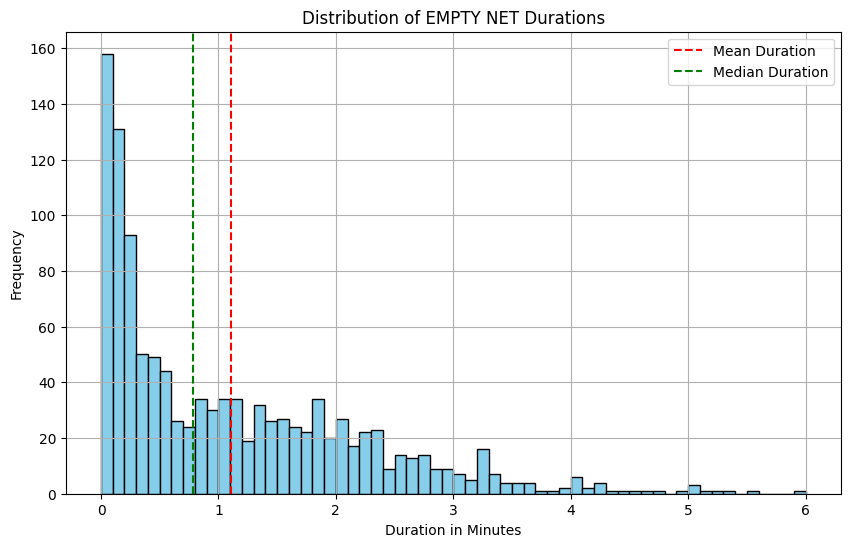

(array([0.03333333, 0.06666667, 0.18333333, 0.78333333, 1.81666667,
        2.62666667, 3.24666667]),
 [5, 10, 25, 50, 75, 90, 95])

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of EMPTY NET durations
plt.figure(figsize=(10, 6))
plt.hist(empty_net_times.dt.total_seconds() / 60, bins=np.arange(0, max_empty_net + 0.1, 0.1), color='skyblue', edgecolor='black')
plt.title('Distribution of EMPTY NET Durations')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')
plt.axvline(x=mean_empty_net, color='red', linestyle='--', label='Mean Duration')
plt.axvline(x=median_empty_net, color='green', linestyle='--', label='Median Duration')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and display the percentiles for further insight
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(empty_net_times.dt.total_seconds() / 60, percentiles)

percentile_values, percentiles


In [42]:
# Filter out EMPTY NET instances shorter than the 25th percentile cutoff (0.18 minutes)
filtered_goalie_stats = goalie_stats[(goalie_stats['Goalie'] != 'EMPTY NET') | (goalie_stats['TimeDelta'] >= timedelta(minutes=0.18))]

# Recalculate the percentage of games with at least one EMPTY NET after filtering
games_with_empty_net_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].nunique()
percentage_empty_net_filtered = (games_with_empty_net_filtered / total_games) * 100

# Recalculate the number of games where both teams had an EMPTY NET after filtering
games_both_teams_empty_net_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Game_ID').filter(lambda x: len(x) > 1)['Game_ID'].nunique()

# Recalculate basic statistics about the length of time EMPTY NET appears in games after filtering
empty_net_times_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['TimeDelta']
min_empty_net_filtered = empty_net_times_filtered.min().total_seconds() / 60
max_empty_net_filtered = empty_net_times_filtered.max().total_seconds() / 60
mean_empty_net_filtered = empty_net_times_filtered.mean().total_seconds() / 60
median_empty_net_filtered = empty_net_times_filtered.median().total_seconds() / 60
std_empty_net_filtered = empty_net_times_filtered.std().total_seconds() / 60

(percentage_empty_net_filtered, games_both_teams_empty_net_filtered, min_empty_net_filtered, max_empty_net_filtered, mean_empty_net_filtered, median_empty_net_filtered, std_empty_net_filtered)


(70.24346257889991,
 91,
 0.18333333333333332,
 5.983333333333333,
 1.4352298833333335,
 1.225,
 1.0646130666666667)

## Aggrigate and tally the time with and againsts empty net

In [43]:
# OUTPUT to csv 
# filtered_goalie_stats
# filtered_goalie_stats.to_csv('filtered_goalie_stats.csv', index=False)

filtered_goalie_stats.head()
## HOTFIX FOR NAME MATCHING ERROR
# Replace any '-' in Team with ' '
filtered_goalie_stats['Team'] = filtered_goalie_stats['Team'].str.replace('-', ' ')

# home team is after 4th - in Game_ID
# away team is 3rd before 4th - in Game_ID
# Create new columns
filtered_goalie_stats['Home_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-1]
filtered_goalie_stats['Away_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-2]

# Drop any games that do not have an EMPTY NET instance
filtered_goalie_stats = filtered_goalie_stats[filtered_goalie_stats['Game_ID'].isin(filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].unique())]

# filtered_goalie_stats.head(10)
# OUTPUT to csv 
# filtered_goalie_stats
filtered_goalie_stats.to_csv('filtered_goalie_stats.csv', index=False)

C:\Users\jbanc\AppData\Local\Temp\ipykernel_7388\3686376507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_goalie_stats['Team'] = filtered_goalie_stats['Team'].str.replace('-', ' ')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_7388\3686376507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_goalie_stats['Home_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-1]
C:\Users\jbanc\AppData\Local\Temp\ipykernel_7388\3686376507.py:14: SettingWithCopyWarning: 
A value is trying 

# SEEMS TO BE WORKING HERE WITH THIS METHOD - 

In [44]:
updated_filtered_goalie_stats = filtered_goalie_stats

# Convert "Minutes" to total minutes as a float for consistency
updated_filtered_goalie_stats['Total_Minutes'] = updated_filtered_goalie_stats['Minutes'].apply(convert_minutes_to_numeric)

# Aggregate the times each team pulled their goalie
teams_pulled_goalie_agg = updated_filtered_goalie_stats[updated_filtered_goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
    Instances_Pulled=('Game_ID', 'count'),
    Total_Time_Pulled=('Total_Minutes', 'sum')
).reset_index()

# For calculating the instances and time faced, we need to determine when the team is not the one with the EMPTY NET
# This involves checking against Home_Team and Away_Team to assign the correct opposing team

# Mark rows where the goalie was pulled (EMPTY NET) to help with opponent calculations
updated_filtered_goalie_stats['Goalie_Pulled'] = updated_filtered_goalie_stats['Goalie'] == 'EMPTY NET'

# Calculate instances and total time faced for each team
def calculate_faced_stats(row):
    if row['Goalie_Pulled']:
        if row['Team'] == row['Home_Team']:
            return row['Away_Team']
        else:
            return row['Home_Team']
    return None

updated_filtered_goalie_stats['Opponent_When_Pulled'] = updated_filtered_goalie_stats.apply(calculate_faced_stats, axis=1)

# Aggregate for opponents faced an EMPTY NET
opponents_faced_agg = updated_filtered_goalie_stats.dropna(subset=['Opponent_When_Pulled']).groupby('Opponent_When_Pulled').agg(
    Instances_Faced=('Game_ID', 'count'),
    Total_Time_Faced=('Total_Minutes', 'sum')
).reset_index().rename(columns={'Opponent_When_Pulled': 'Team'})

# Merge the pulling and facing stats into a single DataFrame
final_aggregated_stats = pd.merge(teams_pulled_goalie_agg, opponents_faced_agg, on='Team', how='outer').fillna(0)

final_aggregated_stats.head()


,Team,Instances_Pulled,Total_Time_Pulled,Instances_Faced,Total_Time_Faced
0,Air Force,18,39.783333,15,20.616667
1,Alaska,16,30.883333,17,23.816667
2,Alaska Anchorage,15,21.616667,13,18.250000
3,American Int'l,15,31.533333,16,27.450000
4,Arizona State,10,8.233333,20,29.983333


# Team Empty Net and Extra Attacker Goals

In [45]:
import pandas as pd

# Load the dataset
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM scoring_summary;", conn)



# Ensure 'PP' column is treated as a string, converting NaN values to empty strings for easier processing
df['PP'] = df['PP'].fillna('')

# Initialize columns for EN and EA goals scored and given up
df['EN_scored'] = df['PP'].apply(lambda x: 'EN' in x).astype(int)
df['EA_scored'] = df['PP'].apply(lambda x: 'EA' in x).astype(int)

# Create a mapping of teams to goals given up
goals_given_up = {team: {'EN_given_up': 0, 'EA_given_up': 0} for team in df['Team'].unique()}

# Iterate over the rows to update the goals given up
for index, row in df.iterrows():
    conceding_team = row['Away_Team'] if row['Team'] == row['Home_Team'] else row['Home_Team']
    if 'EN' in row['PP']:
        goals_given_up[conceding_team]['EN_given_up'] += 1
    if 'EA' in row['PP']:
        goals_given_up[conceding_team]['EA_given_up'] += 1

# Convert the mapping to a DataFrame
goals_given_up_df = pd.DataFrame.from_dict(goals_given_up, orient='index').reset_index()
goals_given_up_df.rename(columns={'index': 'Team'}, inplace=True)

# Merge the scored goals with the given up goals
result_df = df.groupby('Team').agg({'EN_scored': 'sum', 'EA_scored': 'sum'}).reset_index()
result = pd.merge(result_df, goals_given_up_df, on='Team')

print(result)


                Team  EN_scored  EA_scored  EN_given_up  EA_given_up
0          Air Force          5          2           13            4
1             Alaska          4          2            6            5
2   Alaska Anchorage          2          3            4            5
3     American Int'l          9          3            5            4
4      Arizona State          8          0            3            2
..               ...        ...        ...          ...          ...
59             Union          5          6           10            2
60           Vermont          4          2            5            1
61  Western Michigan         12          4            3            0
62         Wisconsin         10          5            6            2
63              Yale          4          0            5            4

[64 rows x 5 columns]


In [46]:
# 3 sort by EN scored
result = result.sort_values(by='EN_scored', ascending=False)

# Calculate the EN Goals Scored to EA Goals Given Up Ration
result['EN_vs_EA_Ratio'] = result['EN_scored'] / result['EA_given_up']

# calulate EA Goals Scored to EN Goals Given Up Ratio
result['EA_vs_EN_Ratio'] = result['EA_scored'] / result['EN_given_up']

result.head(20)



,Team,EN_scored,EA_scored,EN_given_up,EA_given_up,EN_vs_EA_Ratio,EA_vs_EN_Ratio
23,Holy Cross,15,2,4,2,7.500000,0.500000
61,Western Michigan,12,4,3,0,inf,1.333333
34,Michigan State,11,2,5,5,2.200000,0.400000
62,Wisconsin,10,5,6,2,5.000000,0.833333
14,Clarkson,9,3,6,4,2.250000,0.500000
3,American Int'l,9,3,5,4,2.250000,0.600000
40,Niagara,9,1,9,3,3.000000,0.111111
16,Colorado College,8,1,3,2,4.000000,0.333333
4,Arizona State,8,0,3,2,4.000000,0.000000
9,Boston College,8,1,2,3,2.666667,0.500000


In [47]:
## Merge the result with the final_aggregated_stats
final_result = pd.merge(result, final_aggregated_stats, on='Team', how='outer').fillna(0)

final_result.head(20)

,Team,EN_scored,EA_scored,EN_given_up,EA_given_up,EN_vs_EA_Ratio,EA_vs_EN_Ratio,Instances_Pulled,Total_Time_Pulled,Instances_Faced,Total_Time_Faced
0,Holy Cross,15,2,4,2,7.500000,0.500000,11,12.750000,20,29.550000
1,Western Michigan,12,4,3,0,inf,1.333333,13,19.883333,16,17.250000
2,Michigan State,11,2,5,5,2.200000,0.400000,7,8.366667,16,26.616667
3,Wisconsin,10,5,6,2,5.000000,0.833333,14,22.183333,17,21.950000
4,Clarkson,9,3,6,4,2.250000,0.500000,14,28.483333,17,21.583333
5,American Int'l,9,3,5,4,2.250000,0.600000,15,31.533333,16,27.450000
6,Niagara,9,1,9,3,3.000000,0.111111,14,24.133333,15,30.650000
7,Colorado College,8,1,3,2,4.000000,0.333333,11,9.833333,17,20.966667
8,Arizona State,8,0,3,2,4.000000,0.000000,10,8.233333,20,29.983333
9,Boston College,8,1,2,3,2.666667,0.500000,12,9.500000,17,20.183333


In [48]:
# Rearange the columns for better readability
final_result = final_result[['Team', 'Instances_Pulled', 'EA_scored', 'EN_given_up',  'Total_Time_Pulled', 
                             'Instances_Faced', 'EN_scored',  'EA_given_up', 'Total_Time_Faced',
                             'EN_vs_EA_Ratio', 
                             'EA_vs_EN_Ratio']]

# Calculate some rates
final_result['EN_Goals_Scored_Per_Minute'] = final_result['EN_scored'] / final_result['Total_Time_Faced']
# Allowed EN Goals Per Minute
final_result['EN_Goals_Allowed_Per_Minute'] = final_result['EN_given_up'] / final_result['Total_Time_Pulled']
## EA Goals Scored Per Minute
final_result['EA_Goals_Scored_Per_Minute'] = final_result['EA_scored'] / final_result['Total_Time_Pulled']
## EA Goals Allowed Per Minute
final_result['EA_Goals_Allowed_Per_Minute'] = final_result['EA_given_up'] / final_result['Total_Time_Faced']


## Inverse Calculation - amount of time it takes to score a goal / give up a goal in those situations
final_result['Minutes_Per_EN_Goals_Scored'] = final_result['Total_Time_Faced'] / final_result['EN_scored']
final_result['Minutes_Per_EN_Goals_Given_Up'] = final_result['Total_Time_Pulled'] / final_result['EN_given_up']
final_result['Minutes_Per_EA_Goals_Scored'] = final_result['Total_Time_Pulled'] / final_result['EA_scored']
final_result['Minutes_Per_EA_Goals_Given_Up'] = final_result['Total_Time_Faced'] / final_result['EA_given_up']

final_result['Goal/Min EN_vs_EA_Ratio'] = final_result['EN_Goals_Scored_Per_Minute'] / final_result['EA_Goals_Allowed_Per_Minute']
final_result['Goal/Min EA_vs_EN_Ratio'] = final_result['EA_Goals_Scored_Per_Minute'] / final_result['EN_Goals_Allowed_Per_Minute']

# Rename the columns for better readability
final_result['EN_vs_EA_Count_Ratio'] = final_result['EN_vs_EA_Ratio']
final_result['EA_vs_EN_Count_Ratio'] = final_result['EA_vs_EN_Ratio']

# Rearange the columns for better readability
final_result = final_result[['Team', 'Instances_Pulled', 'EA_scored', 'EA_Goals_Scored_Per_Minute', 'Minutes_Per_EA_Goals_Scored',
                             'EN_given_up',  'EN_Goals_Allowed_Per_Minute', 'Minutes_Per_EN_Goals_Given_Up', 'Total_Time_Pulled', 
                             
                             'Instances_Faced', 'EN_scored', 'EN_Goals_Scored_Per_Minute','Minutes_Per_EN_Goals_Scored',
                              'EA_given_up', 'EA_Goals_Allowed_Per_Minute', 'Minutes_Per_EA_Goals_Given_Up', 'Total_Time_Faced',
                              
                              
                              
                              'EN_vs_EA_Count_Ratio', 
                             'EA_vs_EN_Count_Ratio',
                             ]]

final_result.head(20)

,Team,Instances_Pulled,EA_scored,EA_Goals_Scored_Per_Minute,Minutes_Per_EA_Goals_Scored,EN_given_up,EN_Goals_Allowed_Per_Minute,Minutes_Per_EN_Goals_Given_Up,Total_Time_Pulled,Instances_Faced,EN_scored,EN_Goals_Scored_Per_Minute,Minutes_Per_EN_Goals_Scored,EA_given_up,EA_Goals_Allowed_Per_Minute,Minutes_Per_EA_Goals_Given_Up,Total_Time_Faced,EN_vs_EA_Count_Ratio,EA_vs_EN_Count_Ratio
0,Holy Cross,11,2,0.156863,6.375000,4,0.313725,3.187500,12.750000,20,15,0.507614,1.970000,2,0.067682,14.775000,29.550000,7.500000,0.500000
1,Western Michigan,13,4,0.201174,4.970833,3,0.150880,6.627778,19.883333,16,12,0.695652,1.437500,0,0.000000,inf,17.250000,inf,1.333333
2,Michigan State,7,2,0.239044,4.183333,5,0.597610,1.673333,8.366667,16,11,0.413275,2.419697,5,0.187852,5.323333,26.616667,2.200000,0.400000
3,Wisconsin,14,5,0.225394,4.436667,6,0.270473,3.697222,22.183333,17,10,0.455581,2.195000,2,0.091116,10.975000,21.950000,5.000000,0.833333
4,Clarkson,14,3,0.105325,9.494444,6,0.210650,4.747222,28.483333,17,9,0.416988,2.398148,4,0.185328,5.395833,21.583333,2.250000,0.500000
5,American Int'l,15,3,0.095137,10.511111,5,0.158562,6.306667,31.533333,16,9,0.327869,3.050000,4,0.145719,6.862500,27.450000,2.250000,0.600000
6,Niagara,14,1,0.041436,24.133333,9,0.372928,2.681481,24.133333,15,9,0.293638,3.405556,3,0.097879,10.216667,30.650000,3.000000,0.111111
7,Colorado College,11,1,0.101695,9.833333,3,0.305085,3.277778,9.833333,17,8,0.381558,2.620833,2,0.095390,10.483333,20.966667,4.000000,0.333333
8,Arizona State,10,0,0.000000,inf,3,0.364372,2.744444,8.233333,20,8,0.266815,3.747917,2,0.066704,14.991667,29.983333,4.000000,0.000000
9,Boston College,12,1,0.105263,9.500000,2,0.210526,4.750000,9.500000,17,8,0.396367,2.522917,3,0.148637,6.727778,20.183333,2.666667,0.500000


In [49]:
# OUTPUT to csv
final_result.to_csv('../TEMP/EMP_NET_FINALS_TEMP.csv', index=False)

In [51]:
## Sort by Minutes_Per_EA_Goals_Scored
final_result = final_result.sort_values(by='Minutes_Per_EA_Goals_Scored', ascending=True)

# Soft by Minutes per EA Goals Allowed
final_result = final_result.sort_values(by='Minutes_Per_EN_Goals_Given_Up', ascending=True)

final_result.head(20)

,Team,Instances_Pulled,EA_scored,EA_Goals_Scored_Per_Minute,Minutes_Per_EA_Goals_Scored,EN_given_up,EN_Goals_Allowed_Per_Minute,Minutes_Per_EN_Goals_Given_Up,Total_Time_Pulled,Instances_Faced,EN_scored,EN_Goals_Scored_Per_Minute,Minutes_Per_EN_Goals_Scored,EA_given_up,EA_Goals_Allowed_Per_Minute,Minutes_Per_EA_Goals_Given_Up,Total_Time_Faced,EN_vs_EA_Count_Ratio,EA_vs_EN_Count_Ratio
32,Robert Morris,13,2,0.197694,5.058333,9,0.889621,1.124074,10.116667,15,5,0.232019,4.310000,2,0.092807,10.775000,21.550000,2.500000,0.222222
60,Lindenwood,6,2,0.353982,2.825000,4,0.707965,1.412500,5.650000,7,1,0.120240,8.316667,3,0.360721,2.772222,8.316667,0.333333,0.500000
2,Michigan State,7,2,0.239044,4.183333,5,0.597610,1.673333,8.366667,16,11,0.413275,2.419697,5,0.187852,5.323333,26.616667,2.200000,0.400000
29,Omaha,12,0,0.000000,inf,5,0.453172,2.206667,11.033333,18,5,0.240770,4.153333,3,0.144462,6.922222,20.766667,1.666667,0.000000
42,Michigan,11,2,0.126316,7.916667,7,0.442105,2.261905,15.833333,13,4,0.246407,4.058333,4,0.246407,4.058333,16.233333,1.000000,0.285714
20,Bowling Green,15,1,0.054348,18.400000,8,0.434783,2.300000,18.400000,13,6,0.281030,3.558333,0,0.000000,inf,21.350000,inf,0.125000
39,Yale,12,0,0.000000,inf,5,0.412655,2.423333,12.116667,15,4,0.194647,5.137500,4,0.194647,5.137500,20.550000,1.000000,0.000000
26,Minnesota Duluth,15,5,0.342075,2.923333,6,0.410490,2.436111,14.616667,12,5,0.296150,3.376667,3,0.177690,5.627778,16.883333,1.666667,0.833333
49,Rensselaer,14,1,0.050847,19.666667,8,0.406780,2.458333,19.666667,12,3,0.140406,7.122222,8,0.374415,2.670833,21.366667,0.375000,0.125000
31,Penn State,14,3,0.130624,7.655556,9,0.391872,2.551852,22.966667,12,5,0.224888,4.446667,1,0.044978,22.233333,22.233333,5.000000,0.333333
